ImportError: You must be root to use this library on linux.

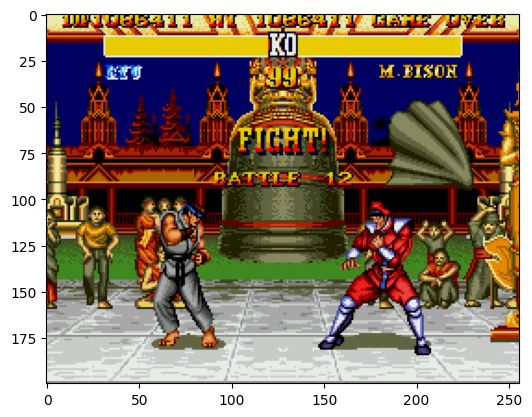

In [1]:
import retro
from matplotlib import pyplot as plt
from IPython import display as ipythondisplay
from IPython.display import HTML

import numpy as np

import gym
from gym.spaces import *

import time

import random

import torch

import readchar

import sys

import keyboard

import PIL
from tqdm import tqdm
import matplotlib.pyplot as plt
import gym
from IPython import display
import cv2

def show_render(env):
    plt.imshow(env.render(mode='rgb_array'))
    display.display(plt.gcf())  
    display.clear_output(wait=True)

class ActionGenerator(object):

    def __init__(self, buttons):
        self.buttons = buttons
        self.p1_sequence = list()
        self.p2_sequence = list()

    def reset(self):
        self.p1_sequence = list()
        self.p2_sequence = list()

    def get_action(self, keys):
        action_list = list()
        for button in self.buttons:
            if button in keys:
                action_list.append(1)
            else:
                action_list.append(0)

        return action_list

    def get_action_for_2(self, p1_keys, p2_keys):
        p1_action = self.get_action(p1_keys)
        p2_action = self.get_action(p2_keys)

        all_action = p1_action
        all_action.extend(p2_action)

        return all_action

    def input_sequence(self, sequence, player='p1'):
        if (player == 'p1'):
            self.p1_sequence.extend(sequence)
        elif (player == 'p2'):
            self.p2_sequence.extend(sequence)
        else:
            pass

    def input_action_string(self, action_string, player='p1'):
        action_list = action_string.split(' ')
        action_sequence = list()
        for action in action_list:
            keys = action.split('_')
            action_sequence.append(keys)

        self.input_sequence(action_sequence, player)

    def get_action_from_sequence(self, player_number=1):
        p1_action_list = list()
        p2_action_list = list()
        for keys in self.p1_sequence:
            action = self.get_action(keys)
            p1_action_list.append(action)

        if (player_number == 1):
            return p1_action_list

        for keys in self.p2_sequence:
            action = self.get_action(keys)
            p2_action_list.append(action)

        p1_action_len = len(p1_action_list)
        p2_action_len = len(p2_action_list)

        larger_index = max(p1_action_len, p2_action_len)

        all_action_list = list()

        null_action = [0] * len(self.buttons)

        for index in range(larger_index):
            if (index < p1_action_len):
                if (index < p2_action_len):
                    all_action_list.append(p1_action_list[index] + p2_action_list[index])
                else:
                    all_action_list.append(p1_action_list[index] + null_action)
            else:
                if (index < p2_action_len):
                    all_action_list.append(null_action + p2_action_list[index])
                else:
                    all_action_list.append(null_action + null_action)

        return all_action_list


class SF2_Action(object):

    def __init__(self, buttons):
        self.Ryu_actions = ['', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'X', 'Y', 'Z', 'A', 'B', 'C',
                            'UP_LEFT', 'UP_RIGHT', 'DOWN_LEFT', 'DOWN_RIGHT',
                            'DOWN DOWN_RIGHT RIGHT Z', 'DOWN DOWN_LEFT LEFT Z',
                            'RIGHT DOWN RIGHT_DOWN Z', 'LEFT DOWN LEFT_DOWN Z',
                            'DOWN RIGHT A', 'DOWN LEFT A']
        self.action_generator = ActionGenerator(buttons)
        self.action_buffer = list()

    def get_random_ryu_action(self):
        random_number = random.randint(0, len(self.Ryu_actions) - 1)
        selected_action = self.Ryu_actions[random_number]
        self.action_generator.reset()
        self.action_generator.input_action_string(selected_action)
        generated_action = self.action_generator.get_action_from_sequence(player_number=2)
        return generated_action

    def get_next_ryu_action(self):
        if (len(self.action_buffer) == 0):
            self.action_buffer.extend(self.get_random_ryu_action())

        action = self.action_buffer.pop(0)

        return action

    def get_action_by_index(self, index):
        selected_action = self.Ryu_actions[index]
        self.action_generator.reset()
        self.action_generator.input_action_string(selected_action)
        generated_action = self.action_generator.get_action_from_sequence(player_number=2)
        return generated_action


def start_testing():
    print('testing')
    env = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis',
                     state='Champion.Level12.RyuVsBison', #'two_player_ryu_ken',
                     use_restricted_actions=retro.Actions.FILTERED,
                     players=2)

    sf2_action = SF2_Action(env.buttons)

    action_generator = ActionGenerator(env.buttons)

    obs = env.reset()

    right_move_string = 'RIGHT NULL NULL NULL '
    down_move_string = 'DOWN NULL NULL NULL '
    z_move_string = 'Z NULL NULL NULL '
    up_move_string = 'UP NULL NULL NULL '

    action_none = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    null_action = action_none

    action_string_list = list()

    for i in range(6):
        result_string = ''
        for j in range(i):
            result_string = result_string + right_move_string
        result_string = result_string + z_move_string
        action_string_list.append(result_string)

    for i in range(6):
        result_string = down_move_string
        for j in range(i):
            result_string = result_string + right_move_string
        result_string = result_string + z_move_string
        action_string_list.append(result_string)

    player_2_action_string_list = list()

    for i in range(6):
        result_string = up_move_string
        for j in range(i):
            result_string = result_string + right_move_string
        result_string = result_string + z_move_string
        player_2_action_string_list.append(result_string)

    for i in range(6):
        result_string = ''
        for j in range(i):
            result_string = result_string + right_move_string
        result_string = result_string + z_move_string
        player_2_action_string_list.append(result_string)

    index = 0
    action_string = action_string_list[index]
    index_2 = 0
    action_string_2 = player_2_action_string_list[index_2]

    obs = env.reset()

    action_generator.reset()
    action_generator.input_action_string(action_string)
    action_generator.input_action_string(action_string_2, player='p2')
    action_list = action_generator.get_action_from_sequence(player_number=2)

    obs = env.reset()

    for action in action_list:
        obs = env.step(action)
        # env.render()
        show_render(env)

    key_maps = dict()

    key_maps['right'] = 'RIGHT'
    key_maps['left'] = 'LEFT'
    key_maps['down'] = 'DOWN'
    key_maps['up'] = 'UP'
    key_maps['a'] = 'A'
    key_maps['b'] = 'B'
    key_maps['c'] = 'C'
    key_maps['x'] = 'X'
    key_maps['y'] = 'Y'
    key_maps['z'] = 'Z'
    key_maps['s'] = 'START'
    key_maps['m'] = 'MODE'

    current_player = 1

    while (True):
        # c = sys.stdin.read(1)
        # c = input('')
        # print(c)
        #
        # if (c == 'q'):
        #     break

        event = keyboard.read_event()
        if event.event_type == keyboard.KEY_DOWN:
            key = event.name
            print(f'Pressed: {key}')
            if key == 'q':
                print('Going to quit the loop')
                break
            elif key == 'p':
                if current_player == 1:
                    print ('Switching to player 2')
                    current_player = 2
                else:
                    print ('Switching to player 1')
                    current_player = 1
            elif key == 'l':
                print ('skipping frame')
                obs = env.step(null_action)
                # env.render()
                show_render(env)
            else:
                if (key in key_maps.keys()):
                    real_action = key_maps[key]
                    action_generator.reset()
                    if (current_player == 1):
                        action_generator.input_action_string(real_action)
                    else:
                        action_generator.input_action_string(real_action, player='p2')

                    action_list = action_generator.get_action_from_sequence(player_number=2)

                    for action in action_list:
                        print (action)
                        obs = env.step(action)
                        # env.render()
                        show_render(env)

                    for i in range(10):
                        obs = env.step(null_action)
                        # env.render()
                        show_render(env)


    # time.sleep(10)

start_testing()